Basis Pursuit DeNoising
=======================

This example demonstrates the use of classes [admm.bpdn.BPDN](http://sporco.rtfd.org/en/latest/modules/sporco.admm.bpdn.html#sporco.admm.bpdn.BPDN) and [pgm.bpdn.BPDN](http://sporco.rtfd.org/en/latest/modules/sporco.pgm.bpdn.html#sporco.pgm.bpdn.BPDN) to solve the Basis Pursuit DeNoising (BPDN) problem [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#chen-1998-atomic)

  $$\mathrm{argmin}_\mathbf{x} \; (1/2) \| D \mathbf{x} - \mathbf{s} \|_2^2 + \lambda \| \mathbf{x} \|_1 \;,$$

where $D$ is the dictionary, $\mathbf{x}$ is the sparse representation, and $\mathbf{s}$ is the signal to be represented. In this example the BPDN problem is used to estimate the reference sparse representation that generated a signal from a noisy version of the signal.

In [1]:
from __future__ import print_function
from builtins import input

import numpy as np

import sporco.admm.bpdn as abpdn
import sporco.pgm.bpdn as pbpdn
from sporco.pgm.backtrack import BacktrackRobust
from sporco import plot
plot.config_notebook_plotting()

Configure problem size, sparsity, and noise level.

In [2]:
N = 512      # Signal size
M = 4*N      # Dictionary size
L = 32       # Number of non-zero coefficients in generator
sigma = 0.5  # Noise level

Construct random dictionary, reference random sparse representation, and test signal consisting of the synthesis of the reference sparse representation with additive Gaussian noise.

In [3]:
# Construct random dictionary and random sparse coefficients
np.random.seed(12345)
D = np.random.randn(N, M)
x0 = np.zeros((M, 1))
si = np.random.permutation(list(range(0, M-1)))
x0[si[0:L]] = np.random.randn(L, 1)

# Construct reference and noisy signal
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(N,1)

Set regularisation parameter.

In [4]:
lmbda = 2.98e1

Set options for ADMM solver.

In [5]:
opt_admm = abpdn.BPDN.Options({'Verbose': False, 'MaxMainIter': 500,
                        'RelStopTol': 1e-3, 'AutoRho': {'RsdlTarget': 1.0}})

Initialise and run ADMM solver object.

In [6]:
ba = abpdn.BPDN(D, s, lmbda, opt_admm)
xa = ba.solve()

print("ADMM BPDN solve time: %.2fs" % ba.timer.elapsed('solve'))

ADMM BPDN solve time: 0.17s


Set options for PGM solver.

In [7]:
opt_pgm = pbpdn.BPDN.Options({'Verbose': True, 'MaxMainIter': 50, 'L': 9e2,
                              'Backtrack': BacktrackRobust()})

Initialise and run PGM solver.

In [8]:
bp = pbpdn.BPDN(D, s, lmbda, opt_pgm)
xp = bp.solve()

print("PGM BPDN solve time: %.2fs" % bp.timer.elapsed('solve'))

Itn   Fnc       DFid      Regℓ1     Rsdl      F         Q         It_Bt  L       
---------------------------------------------------------------------------------
   0  3.09e+03  1.61e+03  4.98e+01  1.68e+00  1.61e+03  2.27e+03      3  3.24e+03
   1  2.41e+03  7.88e+02  5.45e+01  2.01e+00  7.88e+02  9.97e+02      1  2.92e+03
   2  2.12e+03  4.33e+02  5.65e+01  9.08e-01  4.33e+02  5.07e+02      1  2.62e+03
   3  1.93e+03  3.20e+02  5.39e+01  6.26e-01  3.20e+02  3.70e+02      1  2.36e+03
   4  1.78e+03  2.45e+02  5.14e+01  5.64e-01  2.45e+02  2.81e+02      1  2.13e+03
   5  1.64e+03  2.31e+02  4.74e+01  5.60e-01  2.31e+02  2.63e+02      1  1.91e+03
   6  1.52e+03  1.99e+02  4.43e+01  5.78e-01  1.99e+02  2.25e+02      1  1.72e+03
   7  1.40e+03  1.94e+02  4.05e+01  6.01e-01  1.94e+02  2.17e+02      1  1.55e+03
   8  1.29e+03  1.67e+02  3.77e+01  6.33e-01  1.67e+02  1.85e+02      1  1.39e+03
   9  1.18e+03  1.71e+02  3.39e+01  6.61e-01  1.71e+02  1.88e+02      1  1.26e+03
  10  1.08e+03  

Plot comparison of reference and recovered representations.

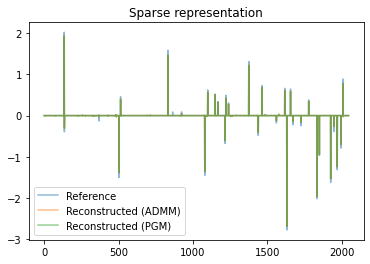

In [9]:
plot.plot(np.hstack((x0, xa, xp)), alpha=0.5, title='Sparse representation',
          lgnd=['Reference', 'Reconstructed (ADMM)',
                'Reconstructed (PGM)'])

Plot functional value, residual, and L

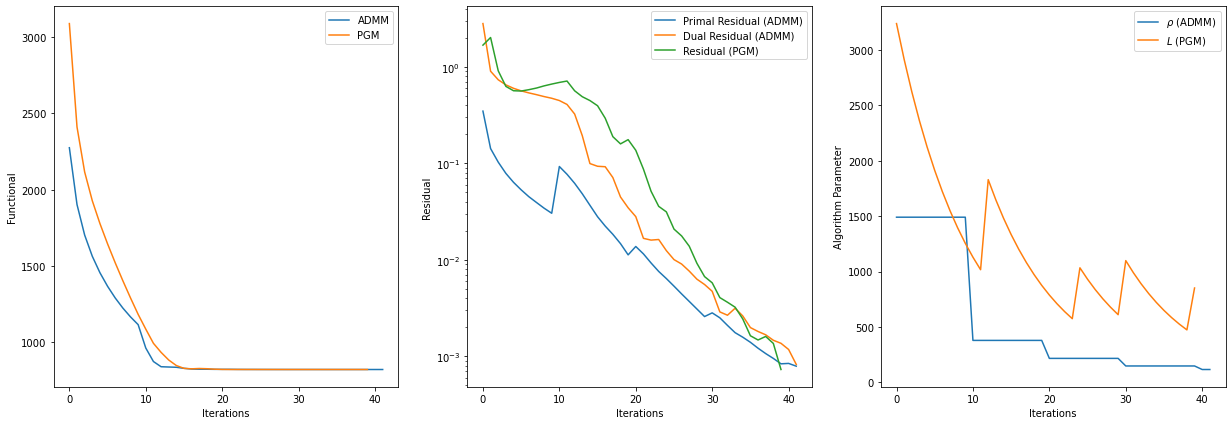

In [10]:
itsa = ba.getitstat()
itsp = bp.getitstat()
fig = plot.figure(figsize=(21, 7))
plot.subplot(1, 3, 1)
plot.plot(itsa.ObjFun, xlbl='Iterations', ylbl='Functional', fig=fig)
plot.plot(itsp.ObjFun, xlbl='Iterations', ylbl='Functional',
          lgnd=['ADMM', 'PGM'], fig=fig)
plot.subplot(1, 3, 2)
plot.plot(itsa.PrimalRsdl, ptyp='semilogy', xlbl='Iterations', ylbl='Residual',
          fig=fig)
plot.plot(itsa.DualRsdl, ptyp='semilogy', fig=fig)
plot.plot(itsp.Rsdl, ptyp='semilogy', lgnd=['Primal Residual (ADMM)',
          'Dual Residual (ADMM)','Residual (PGM)'], fig=fig)
plot.subplot(1, 3, 3)
plot.plot(itsa.Rho, xlbl='Iterations', ylbl='Algorithm Parameter', fig=fig)
plot.plot(itsp.L, lgnd=[r'$\rho$ (ADMM)', '$L$ (PGM)'], fig=fig)
fig.show()